In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import tweepy
from tweepy import OAuthHandler
import os
import re

from timeit import default_timer as timer
from datetime import datetime
from functools import reduce
from nltk import pos_tag

%matplotlib inline

# Gather

In [2]:
#Read CSV file 
twitter_archive = pd.read_csv('twitter-archive-enhanced-2.csv')
twitter_archive.sort_values('timestamp')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Scrape the image predictions file from the Udacity website
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 
response = requests.get(url)
with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

In [4]:
# Load the image predictions file
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
# Save only certain tweet elements in dataframe
elements_to_save = ['id', 'created_at', 'favorite_count', 'retweet_count']
# Later convert list to dataframe
data = []

with open('tweet-json.txt', 'r') as readfile: 
    # Read in JSON line and convert to dict
    tweet_json = readfile.readline()
    
    # Read line by line into DataFrame
    while tweet_json:
        tweet_dict = json.loads(tweet_json)
        # Create a smaller dict
        data_row = dict((k, tweet_dict[k]) for k in elements_to_save)
        data.append(data_row)
        
        # Read in JSON line and convert to dict
        tweet_json = readfile.readline()
        
            
    
df_tweet_json = pd.DataFrame.from_dict(data)

In [6]:
df_tweet_json.head()

,created_at,favorite_count,id,retweet_count
0,Tue Aug 01 16:23:56 +0000 2017,39467,892420643555336193,8853
1,Tue Aug 01 00:17:27 +0000 2017,33819,892177421306343426,6514
2,Mon Jul 31 00:18:03 +0000 2017,25461,891815181378084864,4328
3,Sun Jul 30 15:58:51 +0000 2017,42908,891689557279858688,8964
4,Sat Jul 29 16:00:24 +0000 2017,41048,891327558926688256,9774


In [7]:
df = pd.merge(left=twitter_archive, right=image_predictions, left_on='tweet_id', right_on='tweet_id', how='left')
df = pd.merge(left=df, right=df_tweet_json, left_on='tweet_id', right_on='id', how='left')

In [8]:
del df['id']
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,Tue Aug 01 16:23:56 +0000 2017,39467.0,8853.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,Tue Aug 01 00:17:27 +0000 2017,33819.0,6514.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,Mon Jul 31 00:18:03 +0000 2017,25461.0,4328.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,Sun Jul 30 15:58:51 +0000 2017,42908.0,8964.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,Sat Jul 29 16:00:24 +0000 2017,41048.0,9774.0


# Assessing

In [9]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
twitter_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [13]:
twitter_archive['name'].value_counts()

None         745
a             55
Charlie       12
Lucy          11
Cooper        11
Oliver        11
Tucker        10
Lola          10
Penny         10
Bo             9
Winston        9
the            8
Sadie          8
Daisy          7
Buddy          7
Bailey         7
an             7
Toby           7
Jax            6
Oscar          6
Leo            6
Koda           6
Milo           6
Jack           6
Bella          6
Rusty          6
Stanley        6
Dave           6
Scout          6
Bentley        5
            ... 
Pherb          1
Binky          1
Halo           1
Jay            1
Miley          1
Rover          1
Beemo          1
Bobble         1
Frönq          1
Eriq           1
Sunshine       1
Hector         1
Clybe          1
Mookie         1
Duddles        1
Kramer         1
Dante          1
Shadoe         1
Edmund         1
Monty          1
Fletcher       1
Arlo           1
Jed            1
Enchilada      1
Coopson        1
Bruno          1
Dex            1
Biden         

In [14]:
twitter_archive.sort_values(by='name')['name']

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [15]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [17]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
image_predictions.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [21]:
df_tweet_json

,created_at,favorite_count,id,retweet_count
0,Tue Aug 01 16:23:56 +0000 2017,39467,892420643555336193,8853
1,Tue Aug 01 00:17:27 +0000 2017,33819,892177421306343426,6514
2,Mon Jul 31 00:18:03 +0000 2017,25461,891815181378084864,4328
3,Sun Jul 30 15:58:51 +0000 2017,42908,891689557279858688,8964
4,Sat Jul 29 16:00:24 +0000 2017,41048,891327558926688256,9774
5,Sat Jul 29 00:08:17 +0000 2017,20562,891087950875897856,3261
6,Fri Jul 28 16:27:12 +0000 2017,12041,890971913173991426,2158
7,Fri Jul 28 00:22:40 +0000 2017,56848,890729181411237888,16716
8,Thu Jul 27 16:25:51 +0000 2017,28226,890609185150312448,4429
9,Wed Jul 26 15:59:51 +0000 2017,32467,890240255349198849,7711


In [22]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
created_at        2354 non-null object
favorite_count    2354 non-null int64
id                2354 non-null int64
retweet_count     2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


In [23]:
df_tweet_json.describe()

,favorite_count,id,retweet_count
count,2354.000000,2.354000e+03,2354.000000
mean,8080.968564,7.426978e+17,3164.797366
std,11814.771334,6.852812e+16,5284.770364
min,0.000000,6.660209e+17,0.000000
25%,1415.000000,6.783975e+17,624.500000
50%,3603.500000,7.194596e+17,1473.500000
75%,10122.250000,7.993058e+17,3652.000000
max,132810.000000,8.924206e+17,79515.000000


In [24]:
df_tweet_json.isna().sum()

created_at        0
favorite_count    0
id                0
retweet_count     0
dtype: int64

## Quality Issues
(accuracy, validity, consistency, completeness)

* There were 2075 rows in the image_predictions dataframe compared to 2356 rows in the twitter_archive dataframe. This is due to tweets with no images and retweets included.
* Several columns such as in_reply_to_status, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp and expanded_urls have empty values.
* The name column has a lot of non-name values. The most common name is 'a' which is not actually a name.
* The numerator and denominator columns have wacky values.
* The timestamp type is an object, not a timestamp.
* The text column could be parsed to include gender.
* The text column could also be parsed to include hashtags.
* In several columns null objects are non-null.

## Tidiness Issues
(structural issues)

* The columns predicting the dog breed could be condensed.
* The dog 'stages' have values as columns, instead of one column filled with the values.

## Clean

### Create a Hashtag Column

#### Define
Extract hashtags from 'text' column using .str.extract method and store in a new column 'hashtag'

#### Code

In [25]:
df['hashtag'] = df['text'].str.extract(r"#(\w+)", expand=True)


#### Test

In [26]:
df['hashtag'].value_counts()

BarkWeek                 9
PrideMonth               3
ImWithThor               1
LoveTwitter              1
WomensMarch              1
WKCDogShow               1
NoDaysOff                1
PrideMonthPuppo          1
ScienceMarch             1
FinalFur                 1
GoodDogs                 1
BATP                     1
dogsatpollingstations    1
notallpuppers            1
BellLetsTalk             1
Canada150                1
K9VeteransDay            1
Name: hashtag, dtype: int64

### Convert Timestamp to a Datetime

#### Define
Change the dataype of 'timestamp' column to datetime using pd.to_datetime method

#### Code

In [27]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#### Test

In [28]:
df.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
jpg_url                               object
img_num                              float64
p1                                    object
p1_conf                              float64
p1_dog                                object
p2        

### Convert tweet_id to object datatype

#### Define
Change the dataype of 'tweet_id' column to object using .astype method

#### Code

In [29]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,created_at,favorite_count,retweet_count,hashtag
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,bagel,0.085851,False,banana,0.076110,False,Tue Aug 01 16:23:56 +0000 2017,39467.0,8853.0,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Pekinese,0.090647,True,papillon,0.068957,True,Tue Aug 01 00:17:27 +0000 2017,33819.0,6514.0,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,malamute,0.078253,True,kelpie,0.031379,True,Mon Jul 31 00:18:03 +0000 2017,25461.0,4328.0,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,Labrador_retriever,0.168086,True,spatula,0.040836,False,Sun Jul 30 15:58:51 +0000 2017,42908.0,8964.0,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,Sat Jul 29 16:00:24 +0000 2017,41048.0,9774.0,BarkWeek


In [30]:
df['tweet_id'] = df['tweet_id'].astype('object')

#### Test

In [31]:
df.dtypes

tweet_id                              object
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
jpg_url                               object
img_num                              float64
p1                                    object
p1_conf                              float64
p1_dog                                object
p2        

### Remove Retweets and Tweets without Pictures

#### Define
* Remove tweets without pictures by including only those rows where 'jpg_url' is not null.
* Remove retweets by including only those rows where 'retweeted_status_id' is null.
* Drop the columns related to retweets

#### Code

In [32]:
# Remove tweets without pictures
df = df[pd.notnull(df['jpg_url'])]

# Remove retweets
df = df[pd.isnull(df['retweeted_status_id'])]

In [33]:
# Drop columns related to retweets
del df['retweeted_status_id']
del df['retweeted_status_user_id']
del df['retweeted_status_timestamp']

#### Test

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 29 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2           

### Condense 'Dog Type' Columns

#### Define
* Use for loop and .str.contains() to re-identify if text contains each column header. Include text if it is found. If not, return NaN.
* Create a column called dog_satge and merge all data in order of puppo, pupper, floofer, doggo using .fillna().
* Drop the redundant columns.
* Change datatype of dog_stage to categorical.

#### Code

In [35]:
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
dog_stages

['doggo', 'floofer', 'pupper', 'puppo']

In [36]:
def find_dog_stage(df, dog_stage):
    dog_list = []
    for row in df['text']:
        if dog_stage in row:
            dog_list.append(dog_stage)
        else:
            dog_list.append(np.NaN)
    return dog_list

In [37]:
for dog_stage in dog_stages:
    df[dog_stage] = find_dog_stage(df, dog_stage)

In [38]:
# Check non-null data counts for columns
df[dog_stages].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 4 columns):
doggo      76 non-null object
floofer    3 non-null object
pupper     229 non-null object
puppo      28 non-null object
dtypes: object(4)
memory usage: 77.9+ KB


In [39]:
# Compare to counts from text
for dog_stage in dog_stages:
    print(dog_stage, df.text.str.contains(dog_stage).sum())

doggo 76
floofer 3
pupper 229
puppo 28


The counts of what is found in the text strings matches with what is found in the respective columns.

In [40]:
df['dog_stage'] = df.puppo.fillna(df.pupper.fillna(df.floofer.fillna(df.doggo)))

In [41]:
df.dog_stage.value_counts()

pupper     229
doggo       66
puppo       28
floofer      3
Name: dog_stage, dtype: int64

So just 10 counts less in doggo as compared to earlier

In [42]:
# Delete those redundant columns
df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [43]:
# Change datatype of dog_stage to categorical
df['dog_stage'] = df['dog_stage'].astype('category')

#### Test

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 26 columns):
tweet_id                 1994 non-null object
in_reply_to_status_id    23 non-null float64
in_reply_to_user_id      23 non-null float64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null object
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog                   1994 non-null object
p3                       1994 non-null object
p3_conf     

### Condense Dog Breed Analysis

#### Define
* Create condensed 'dog_breed' and 'confidence' columns from the respective spread out columns using a function consisting of if else statements.
* Delete the redundant columns.

#### Code

In [45]:
dog_breed = []
confidence = []

def breed_confidence(row):
    if row['p1_dog'] == True:
        dog_breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        dog_breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        dog_breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        dog_breed.append('Unidentifiable')
        confidence.append(0)

df.apply(breed_confidence, axis=1)
df['dog_breed'] = dog_breed
df['confidence'] = confidence
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p3,p3_conf,p3_dog,created_at,favorite_count,retweet_count,hashtag,dog_stage,dog_breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,banana,0.076110,False,Tue Aug 01 16:23:56 +0000 2017,39467.0,8853.0,NaN,NaN,Unidentifiable,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,papillon,0.068957,True,Tue Aug 01 00:17:27 +0000 2017,33819.0,6514.0,NaN,NaN,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,kelpie,0.031379,True,Mon Jul 31 00:18:03 +0000 2017,25461.0,4328.0,NaN,NaN,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,spatula,0.040836,False,Sun Jul 30 15:58:51 +0000 2017,42908.0,8964.0,NaN,NaN,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,German_short-haired_pointer,0.175219,True,Sat Jul 29 16:00:24 +0000 2017,41048.0,9774.0,BarkWeek,NaN,basset,0.555712


In [46]:
# Delete those redundant columns
df.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',], axis=1, inplace=True)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,created_at,favorite_count,retweet_count,hashtag,dog_stage,dog_breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Tue Aug 01 16:23:56 +0000 2017,39467.0,8853.0,NaN,NaN,Unidentifiable,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Tue Aug 01 00:17:27 +0000 2017,33819.0,6514.0,NaN,NaN,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Mon Jul 31 00:18:03 +0000 2017,25461.0,4328.0,NaN,NaN,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Sun Jul 30 15:58:51 +0000 2017,42908.0,8964.0,NaN,NaN,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Sat Jul 29 16:00:24 +0000 2017,41048.0,9774.0,BarkWeek,NaN,basset,0.555712


#### Test

In [47]:
df.dog_breed.value_counts()

Unidentifiable                 308
golden_retriever               158
Labrador_retriever             108
Pembroke                        95
Chihuahua                       91
pug                             62
toy_poodle                      51
chow                            48
Pomeranian                      42
Samoyed                         42
malamute                        33
French_bulldog                  31
Chesapeake_Bay_retriever        31
cocker_spaniel                  30
miniature_pinscher              25
Eskimo_dog                      22
German_shepherd                 21
Cardigan                        21
Staffordshire_bullterrier       21
Siberian_husky                  20
beagle                          20
Shih-Tzu                        20
Shetland_sheepdog               19
Maltese_dog                     19
Rottweiler                      19
Lakeland_terrier                18
kuvasz                          18
basset                          17
Italian_greyhound   

### Remove Redundant Columns

#### Define
* Delete the 'in_reply_to_status_id' and 'in_reply_to_user_id' columns because of no useful info.

#### Code

In [48]:
df['in_reply_to_status_id'].value_counts()
df['in_reply_to_user_id'].value_counts()

4.196984e+09    23
Name: in_reply_to_user_id, dtype: int64

In [49]:
# The ['in_reply_to_user_id'] are all 4196983835, which is @dog_rates, so this info is not useful
df.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

#### Test

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id              1994 non-null object
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
jpg_url               1994 non-null object
img_num               1994 non-null float64
created_at            1994 non-null object
favorite_count        1994 non-null float64
retweet_count         1994 non-null float64
hashtag               22 non-null object
dog_stage             326 non-null category
dog_breed             1994 non-null object
confidence            1994 non-null float64
dtypes: category(1), datetime64[ns](1), float64(4), int64(2), object(9)
memory usage: 267.0+ KB


### Parse Dog Rates and Dog Count

#### Define
* Parse ratings and dog count from 'text' column using lambda function and for loop with if-else statements.
* Drop the redundant 'rating_numerator' and 'rating_denominator' columns.

#### Code

In [51]:
rates = []

extract_rates = lambda x: rates.append(re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x, flags=0))

df['text'].apply(extract_rates)

numerator = []
dog_count = []

for item in rates:
    
    # for tweets with no rating, but a picture, so a dog
    if len(item) == 0:
        numerator.append('NaN')
        dog_count.append(1)
        
    # for tweets with one rating and one dog
    elif len(item) == 1 and item[0][-1] == '10':
        numerator.append(float(item[0][0]))
        dog_count.append(1)
   
    # for group ratings
    elif len(item) == 1: 
        avg = float(item[0][0]) / (float(item[0][-1]) / 10) 
        numerator.append(avg)
        dog_count.append(float(item[0][-1]) / 10)
   
    # for tweets with more than one rating
    elif len(item) > 1: 
        total = 0
        list = []
        for i in range(len(item)):
            if item[i][-1] == '10': #one tweet has the phrase '50/50' so I'm coding to exclude it
                list.append(item[i])
        for rate in list:
            total = total + float(rate[0])
        avg = total / len(item)
        numerator.append(avg)
        dog_count.append(len(item))
   
    # in order to catch bugs
    else:
        numerator.append('Not parsed')
        dog_count.append('Not parsed') 
        
df['rating'] = numerator # not need to also add denominator since they are all 10!
df['dog_count'] = dog_count
df['rating'].value_counts()

12.0                 453
10.0                 411
11.0                 399
13.0                 261
9.0                  152
8.0                   94
7.0                   52
14.0                  36
6.0                   32
5.0                   30
3.0                   19
4.0                   14
2.0                    9
8.5                    4
1.0                    4
7.5                    3
9.5                    3
6.5                    2
5.5                    2
10.5                   2
0.0                    2
1776.0                 1
9.75                   1
9.666666666666666      1
4.5                    1
NaN                    1
11.27                  1
13.5                   1
420.0                  1
11.5                   1
11.26                  1
Name: rating, dtype: int64

In [52]:
# All are below 14 except the joke ratings of 420 and 1776, so success!
# Drop these columns no longer needed
df.drop([ 'rating_numerator', 'rating_denominator'], axis=1, inplace=True)

#### Test

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id          1994 non-null object
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
name              1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null float64
created_at        1994 non-null object
favorite_count    1994 non-null float64
retweet_count     1994 non-null float64
hashtag           22 non-null object
dog_stage         326 non-null category
dog_breed         1994 non-null object
confidence        1994 non-null float64
rating            1994 non-null object
dog_count         1994 non-null float64
dtypes: category(1), datetime64[ns](1), float64(5), object(10)
memory usage: 267.0+ KB


In [54]:
df['dog_count'].value_counts()

1.0     1958
2.0       23
5.0        2
8.0        2
3.0        1
12.0       1
11.0       1
13.0       1
4.0        1
9.0        1
17.0       1
15.0       1
7.0        1
Name: dog_count, dtype: int64

### Extract Names

#### Define
* Split text using str.split
* Create a function to identify names from the split text and add a new column names.
* Drop the redundant 'name' column.

#### Code

In [55]:
df['text_split'] = df['text'].str.split()
df['text_split']

0       [This, is, Phineas., He's, a, mystical, boy., ...
1       [This, is, Tilly., She's, just, checking, pup,...
2       [This, is, Archie., He, is, a, rare, Norwegian...
3       [This, is, Darla., She, commenced, a, snooze, ...
4       [This, is, Franklin., He, would, like, you, to...
5       [Here, we, have, a, majestic, great, white, br...
6       [Meet, Jax., He, enjoys, ice, cream, so, much,...
7       [When, you, watch, your, owner, call, another,...
8       [This, is, Zoey., She, doesn't, want, to, be, ...
9       [This, is, Cassie., She, is, a, college, pup.,...
10      [This, is, Koda., He, is, a, South, Australian...
11      [This, is, Bruno., He, is, a, service, shark.,...
12      [Here's, a, puppo, that, seems, to, be, on, th...
13      [This, is, Ted., He, does, his, best., Sometim...
14      [This, is, Stuart., He's, sporting, his, favor...
15      [This, is, Oliver., You're, witnessing, one, o...
16      [This, is, Jim., He, found, a, fren., Taught, ...
17      [This,

In [56]:
names = []

# Use string startswith method to clean this up

def extract_names(row):
    
    # 'This is Charlie'
    if row['text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    
    # 'Meet Charlie'
    elif row['text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    
    # 'Say hello to Charlie'
    elif row['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # 'Here we have Charlie'
    elif row['text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # 'named Charlie'           
    elif 'named' in row['text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
            
    else:
        names.append('Nameless')
        
        
df.apply(extract_names, axis=1)

len(names)
df['names'] = names
df['names'].value_counts()

Nameless          625
Charlie            11
Cooper             10
Oliver             10
Lucy               10
Penny               9
Tucker              9
Winston             8
Sadie               8
Lola                7
Daisy               7
Bella               6
Stanley             6
Toby                6
Koda                6
Bo                  6
Jax                 6
Rusty               5
Scout               5
Chester             5
Oscar               5
Louis               5
Bailey              5
Leo                 5
Milo                5
Buddy               5
Gary                4
Clarence            4
Reggie              4
Derek               4
                 ... 
Rover               1
William             1
Cupid               1
Rufio               1
Alfonso.            1
Octaviath.          1
Duddles             1
Mookie              1
Tanner              1
Gustav              1
Ivar                1
Guss.               1
Bode                1
Zeus                1
Griswold  

In [57]:
df.drop(['name'], axis=1, inplace=True)

#### Test

In [58]:
df['names'].value_counts()

Nameless          625
Charlie            11
Cooper             10
Oliver             10
Lucy               10
Penny               9
Tucker              9
Winston             8
Sadie               8
Lola                7
Daisy               7
Bella               6
Stanley             6
Toby                6
Koda                6
Bo                  6
Jax                 6
Rusty               5
Scout               5
Chester             5
Oscar               5
Louis               5
Bailey              5
Leo                 5
Milo                5
Buddy               5
Gary                4
Clarence            4
Reggie              4
Derek               4
                 ... 
Rover               1
William             1
Cupid               1
Rufio               1
Alfonso.            1
Octaviath.          1
Duddles             1
Mookie              1
Tanner              1
Gustav              1
Ivar                1
Guss.               1
Bode                1
Zeus                1
Griswold  

### Parse Dog Gender

#### Define
* Identifying pronouns using NLTK.
* Create a function to identify dog gender.
* Remove the redundant columns 'text_split', 'tagged' and 'pronouns'.
* Change datatype of gender to categorical.

#### Code

In [59]:
tagger = lambda x: pos_tag(x)
df['tagged'] = df['text_split'].apply(tagger)

In [60]:
pronouner = lambda x: [word for word, pos in x if pos == 'PRP']
df['pronouns'] = df['tagged'].apply(pronouner)
lowerer = lambda x: [a.lower() for a in x]
df['pronouns'] = df['pronouns'].apply(lowerer)
df['pronouns'].head(10)

0                    []
1                    []
2             [he, you]
3             [she, us]
4    [he, you, him, he]
5                  [we]
6              [he, he]
7      [you, they, you]
8                 [she]
9                 [she]
Name: pronouns, dtype: object

In [61]:
pronouns = df['pronouns']
pronouns

0                       []
1                       []
2                [he, you]
3                [she, us]
4       [he, you, him, he]
5                     [we]
6                 [he, he]
7         [you, they, you]
8                    [she]
9                    [she]
10                    [he]
11                    [he]
12                      []
13                    [he]
14                      []
15                      []
16               [he, him]
17      [he, you, it, him]
18                      []
20            [he, he, he]
21                    [he]
22                      []
23             [she, they]
24              [you, you]
25                    [we]
26                      []
27                    [he]
28                      []
29                      []
31                      []
               ...        
2326                    []
2327                    []
2328                    []
2329                    []
2330                    []
2331                  [we]
2

In [62]:
gender = []

male = ['he', 'him', 'his', "he's", 'himself']
female = ['she', 'her', 'hers', 'herself', "she's"]

def genderer(row):
    row['text'] = row['text'].islower()
    if len(row['pronouns']) > 0 and any(i in female for i in row['pronouns']):
        gender.append('Female')
    elif len(row['pronouns']) > 0 and any(i in male for i in row['pronouns']):
        gender.append('Male') 
    elif 'girl' in str(row['text']):
        gender.append('Female')   
    elif 'boy' in str(row['text']):
        gender.append('Male')
    else:
        gender.append('Neutral')
        
df.apply(genderer, axis=1)
df['gender'] = gender
df['gender'].value_counts()

Neutral    1287
Male        529
Female      178
Name: gender, dtype: int64

In [63]:
df.drop(['text_split', 'tagged', 'pronouns'], axis=1, inplace=True)

In [64]:
# Change datatype of gender to categorical
df['gender'] = df['gender'].astype('category')

#### Test

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id          1994 non-null object
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null float64
created_at        1994 non-null object
favorite_count    1994 non-null float64
retweet_count     1994 non-null float64
hashtag           22 non-null object
dog_stage         326 non-null category
dog_breed         1994 non-null object
confidence        1994 non-null float64
rating            1994 non-null object
dog_count         1994 non-null float64
names             1994 non-null object
gender            1994 non-null category
dtypes: category(2), datetime64[ns](1), float64(5), object(10)
memory usage: 269.0+ KB


## Set Null Values in Various Columns

#### Define
* Set null values where gender is Neutral, name is Nameless, dog_breed is Unidentifiable, dog_stage is None, rating is 0.0 and confidence is 0.0

#### Code

In [66]:
df.loc[df['gender'] == 'Neutral', 'gender'] = None
df.loc[df['names'] == 'Nameless', 'names'] = None
df.loc[df['dog_breed'] == 'Unidentifiable', 'dog_breed'] = None
df.loc[df['dog_stage'] == 'None', 'dog_stage'] = None
df.loc[df['rating'] == 0.0, 'rating'] = np.nan
df.loc[df['confidence'] == 0.0, 'confidence'] = np.nan

#### Test

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id          1994 non-null object
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null float64
created_at        1994 non-null object
favorite_count    1994 non-null float64
retweet_count     1994 non-null float64
hashtag           22 non-null object
dog_stage         326 non-null category
dog_breed         1686 non-null object
confidence        1686 non-null float64
rating            1992 non-null object
dog_count         1994 non-null float64
names             1369 non-null object
gender            707 non-null category
dtypes: category(2), datetime64[ns](1), float64(5), object(10)
memory usage: 269.0+ KB


In [68]:
df.to_csv('twitter_archive_master.csv', encoding = 'utf-8')

# Analysis

In [69]:
df = pd.read_csv('twitter_archive_master.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 19 columns):
Unnamed: 0        1994 non-null int64
tweet_id          1994 non-null int64
timestamp         1994 non-null datetime64[ns]
source            1994 non-null object
text              1994 non-null object
expanded_urls     1994 non-null object
jpg_url           1994 non-null object
img_num           1994 non-null float64
created_at        1994 non-null object
favorite_count    1994 non-null float64
retweet_count     1994 non-null float64
hashtag           22 non-null object
dog_stage         326 non-null object
dog_breed         1686 non-null object
confidence        1686 non-null float64
rating            1991 non-null float64
dog_count         1994 non-null float64
names             1369 non-null object
gender            707 non-null object
dtypes: datetime64[ns](1), float64(6), int64(2), object(10)
memory usage: 296.1+ KB


In [70]:
# Set the size of figures
plt.rcParams['figure.figsize'] = (12, 8)
# Set the font size of axis labels
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

## Retweets, Favorites and Ratings Correlation

Text(0, 0.5, 'Count')

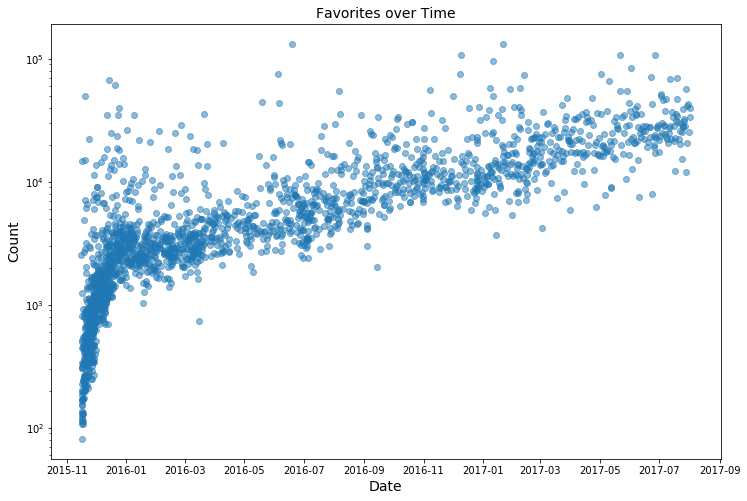

In [71]:
fig, ax = plt.subplots()
ax.plot_date(x=df['timestamp'], y=df['favorite_count'], alpha=0.5)
ax.set_yscale('log')
plt.title('Favorites over Time')
plt.xlabel('Date')
plt.ylabel('Count')
# df[['favorite_count', 'retweet_count']].plot(style='.', alpha = .2)
# plt.title('Favorites and Retweets over Time')
# plt.xlabel('Date')
# plt.ylabel('Count')

Text(0, 0.5, 'Count')

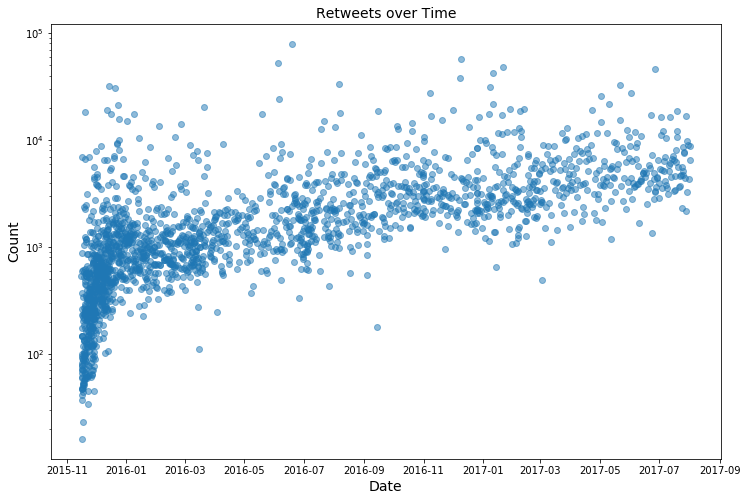

In [72]:
fig, ax = plt.subplots()
ax.plot_date(x=df['timestamp'], y=df['retweet_count'], alpha=0.5)
ax.set_yscale('log')
plt.title('Retweets over Time')
plt.xlabel('Date')
plt.ylabel('Count')

Text(0, 0.5, 'Rating')

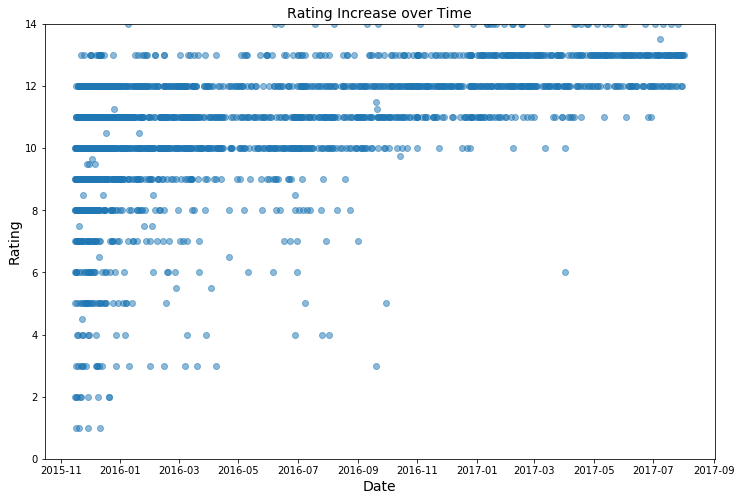

In [73]:
plt.plot_date(x=df['timestamp'], y=df['rating'], alpha=.5)
plt.ylim(0,14)
plt.title('Rating Increase over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

In [74]:
df[['favorite_count', 'retweet_count', 'rating']].corr(method='pearson')

,favorite_count,retweet_count,rating
favorite_count,1.000000,0.912947,0.016028
retweet_count,0.912947,1.000000,0.018266
rating,0.016028,0.018266,1.000000


There is a correlation between favorites and retweets.
There is no correlation between rating and retweets or favorites.

## 'Good Boys' and 'Good Girls'

Text(0.5, 1.0, 'Dog Genders')

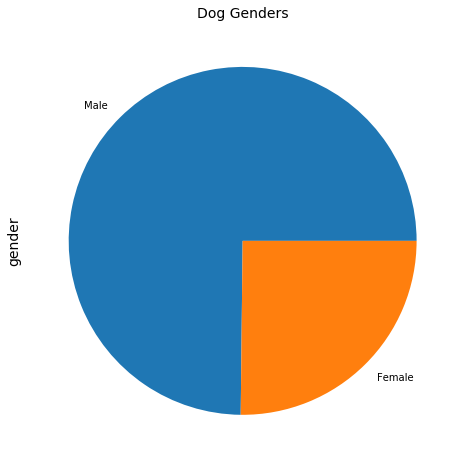

In [75]:
df[df['gender'].notnull()]['gender'].value_counts().plot(kind = 'pie')
plt.title('Dog Genders')

There were three times more male dogs identified than female dogs.

## Most Rated Breeds

Text(0, 0.5, 'Breed')

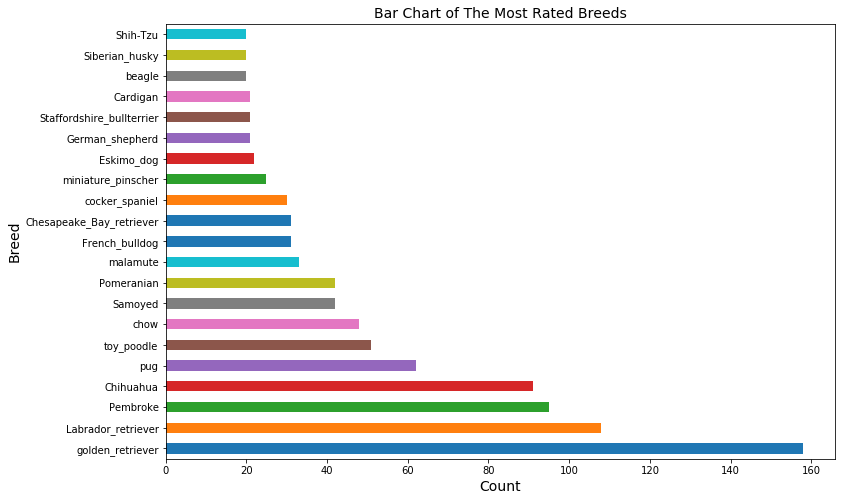

In [76]:
top_breeds=df.groupby('dog_breed').filter(lambda x: len(x) >= 20)
top_breeds['dog_breed'].value_counts().plot(kind = 'barh')
plt.title('Bar Chart of The Most Rated Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')

In [77]:
top_breeds.groupby('dog_breed')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed,,,,,,,,
Cardigan,21.0,11.142857,1.590148,7.0,10.00,11.00,12.0,13.0
Chesapeake_Bay_retriever,31.0,10.741935,1.510358,8.0,10.00,10.00,12.0,13.0
Chihuahua,91.0,10.516484,2.071568,3.0,9.50,11.00,12.0,14.0
Eskimo_dog,22.0,11.409091,1.402688,9.0,10.00,12.00,12.0,14.0
French_bulldog,31.0,11.193548,1.796652,8.0,10.00,12.00,12.0,14.0
German_shepherd,21.0,11.000000,1.449138,8.0,10.00,11.00,12.0,13.0
Labrador_retriever,108.0,11.180556,1.324567,7.0,10.00,11.00,12.0,14.0
Pembroke,95.0,11.389474,1.746088,4.0,11.00,12.00,12.0,14.0
Pomeranian,42.0,10.779762,1.619435,6.0,10.00,11.00,12.0,14.0


In [78]:
df['rating'].describe()

count    1991.000000
mean       11.647638
std        40.668547
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating, dtype: float64

Here we have a statistical description of the top breeds compared to the statistical description of all the ratings. Only one of the top breeds has a mean higher than the total population mean. That might be because of the joke ratings of 420 and 1776 pulling up the total population mean.

In [79]:
df[df['rating'] <= 14]['rating'].describe()

count    1989.000000
mean       10.555277
std         2.157977
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating, dtype: float64

So I adjusted the ratings to exclude the joke rates and now the mean is 10.555. Only five of the top 21 breeds have means under the total population's average. So these breeds are rated higher than average.

## Dog Stages Stats

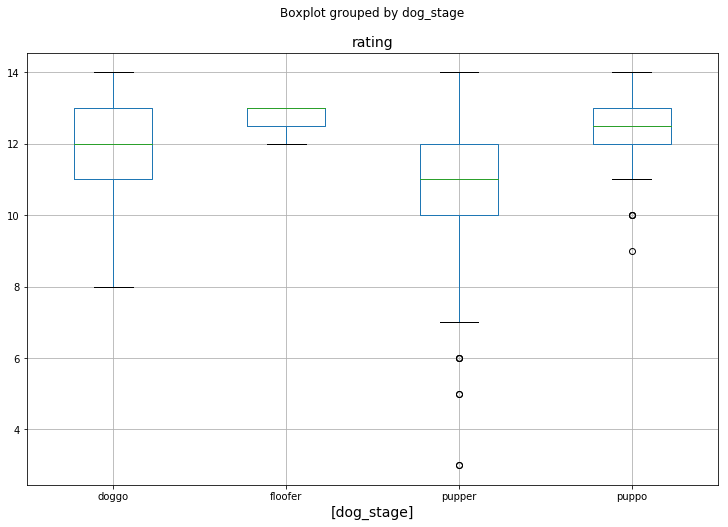

In [80]:
df.boxplot(column=['rating'], by=['dog_stage'])

In [81]:
df.groupby('dog_stage')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,66.0,11.757576,1.478675,8.0,11.0,12.0,13.0,14.0
floofer,3.0,12.666667,0.577350,12.0,12.5,13.0,13.0,13.0
pupper,229.0,10.562271,1.837045,3.0,10.0,11.0,12.0,14.0
puppo,28.0,12.142857,1.208436,9.0,12.0,12.5,13.0,14.0


So puppers are getting much lower rates than the other dog types. Their median is lower and they have several low outliers. This makes sense since 'pupper' can be used to describe irresponsible dogs.

Floofers are consistently rated above 10. I wonder if that is because they are always awesome or if it is based on time. We know that the ratings have been getting higher. If 'floof' is a newer term, only used in newer tweets, that might explain the consistently higher rates.

In [82]:
df.groupby('dog_stage')['timestamp'].describe()

,count,unique,top,freq,first,last
dog_stage,,,,,,
doggo,66,66,2016-11-18 23:35:32,1,2016-04-02 01:52:38,2017-07-26 15:59:51
floofer,3,3,2016-11-20 17:20:08,1,2016-09-15 00:36:55,2017-07-07 16:22:55
pupper,229,229,2016-01-30 02:41:58,1,2015-11-26 21:36:12,2017-07-15 23:25:31
puppo,28,28,2017-01-29 02:44:34,1,2016-06-03 01:07:16,2017-07-25 01:55:32


Here we see that 'floof' is not a new term, first used in January 2016. So that means we can conclude that the floofers are consistently great dogs.